In [56]:
pip install scikit-optimize category_encoders

Barrier


In [57]:
import pandas as pd # pandas for data manipulation and dataframes
import os # os to work with local machines operating system
import kagglehub # kagglehub lets us download the dataset from the kaggle website

path = kagglehub.dataset_download("pilarpieiro/tabular-dataset-ready-for-malicious-url-detection")
print("Path to dataset files:", path)
csv_path = os.path.join(path, "test_dataset.csv")
df = pd.read_csv(csv_path)
print(list(df.columns))
df=df.head(1000000)

Using Colab cache for faster access to the 'tabular-dataset-ready-for-malicious-url-detection' dataset.
Path to dataset files: /kaggle/input/tabular-dataset-ready-for-malicious-url-detection
['url', 'label', 'source', 'url_has_login', 'url_has_client', 'url_has_server', 'url_has_admin', 'url_has_ip', 'url_isshorted', 'url_len', 'url_entropy', 'url_hamming_1', 'url_hamming_00', 'url_hamming_10', 'url_hamming_01', 'url_hamming_11', 'url_2bentropy', 'url_3bentropy', 'url_count_dot', 'url_count_https', 'url_count_http', 'url_count_perc', 'url_count_hyphen', 'url_count_www', 'url_count_atrate', 'url_count_hash', 'url_count_semicolon', 'url_count_underscore', 'url_count_ques', 'url_count_equal', 'url_count_amp', 'url_count_letter', 'url_count_digit', 'url_count_sensitive_financial_words', 'url_count_sensitive_words', 'url_nunique_chars_ratio', 'path_len', 'path_count_no_of_dir', 'path_count_no_of_embed', 'path_count_zero', 'path_count_pertwent', 'path_has_any_sensitive_words', 'path_count_lo

In [58]:
df['source'].value_counts() # displ

,count
source,
dmoz_harvard,285504
data_clean_train_mendel,135959
alexatop1m,118501
domcop,94871
phishtank,79813
ALL-phishing-links,73478
majestic_million,66617
ALL-phishing-domains,56335
tranco_K2K4W,44646


In [59]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='label')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state =3)

In [60]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=3))
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [61]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
   'clf__max_depth' : Integer(2,8),
   'clf__learning_rate' : Real(0.001, 1.0, prior='log-uniform'),
   'clf__subsample' : Real(0.5,1.0),
   'clf__colsample_bytree' : Real(0.5,1.0),
   'clf__colsample_bylevel' : Real(0.5,1.0),
   'clf__colsample_bynode' : Real(0.5,1.0),
   'clf__reg_alpha' : Real(0.0,10.0),
   'clf__reg_lambda' : Real(0.0,10.0),
   'clf__gamma' : Real(0.0,10.0),
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=3)

In [62]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       feature_weights=None,
                                                       gamma=None,
                                                       grow_policy=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [63]:
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder(cols=['url', 'source', 'tld'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.9275769459765062,
                               colsample_bynode=0.615873616651108,
                               colsample_bytree=0.9017296699760271, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, featur...
                               gamma=0.08342580673110335, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0031856662013201725,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [64]:
opt.best_score_

np.float64(0.9986677621406966)

In [65]:
opt.score(X_test, y_test)

np.float64(0.9984696485830994)

In [66]:
opt.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [67]:
opt.predict_proba(X_test)

array([[0.84326583, 0.15673418],
       [0.7622097 , 0.23779027],
       [0.8428884 , 0.15711157],
       ...,
       [0.84332454, 0.15667547],
       [0.843406  , 0.15659396],
       [0.84332454, 0.15667547]], dtype=float32)

In [68]:
opt.best_estimator_.steps

[('encoder', TargetEncoder(cols=['url', 'source', 'tld'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.9275769459765062,
                colsample_bynode=0.615873616651108,
                colsample_bytree=0.9017296699760271, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=0.08342580673110335, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.0031856662013201725,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=7, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, ...))]

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

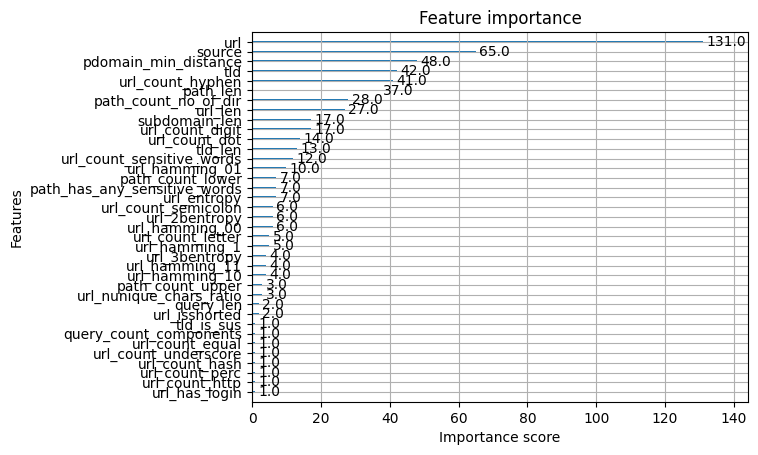

In [69]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

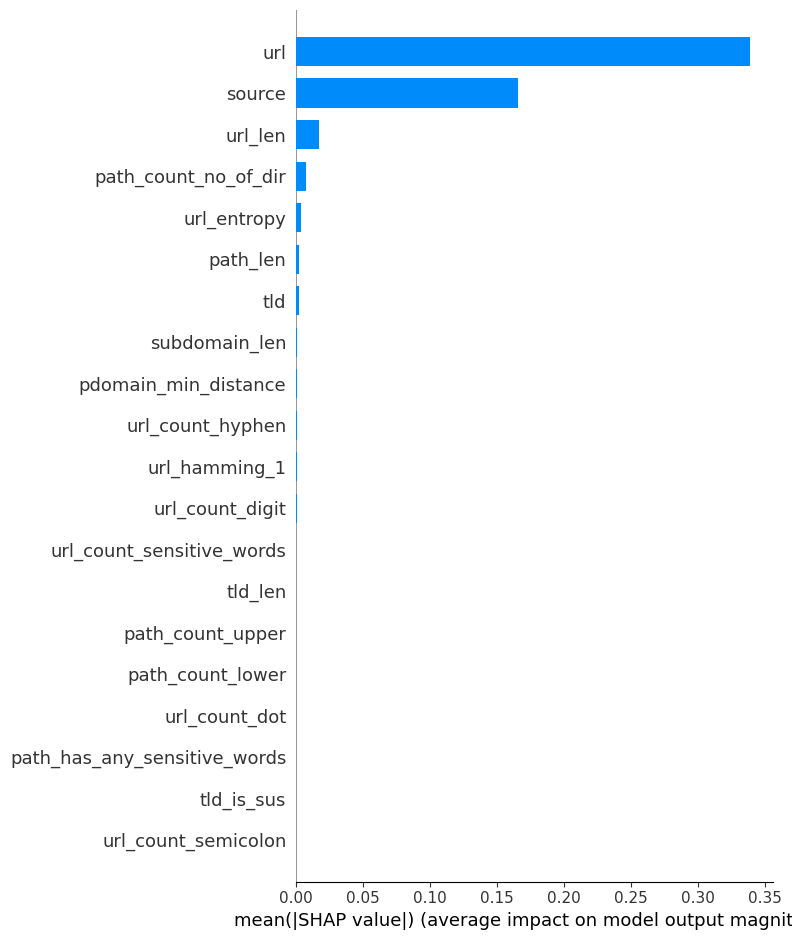

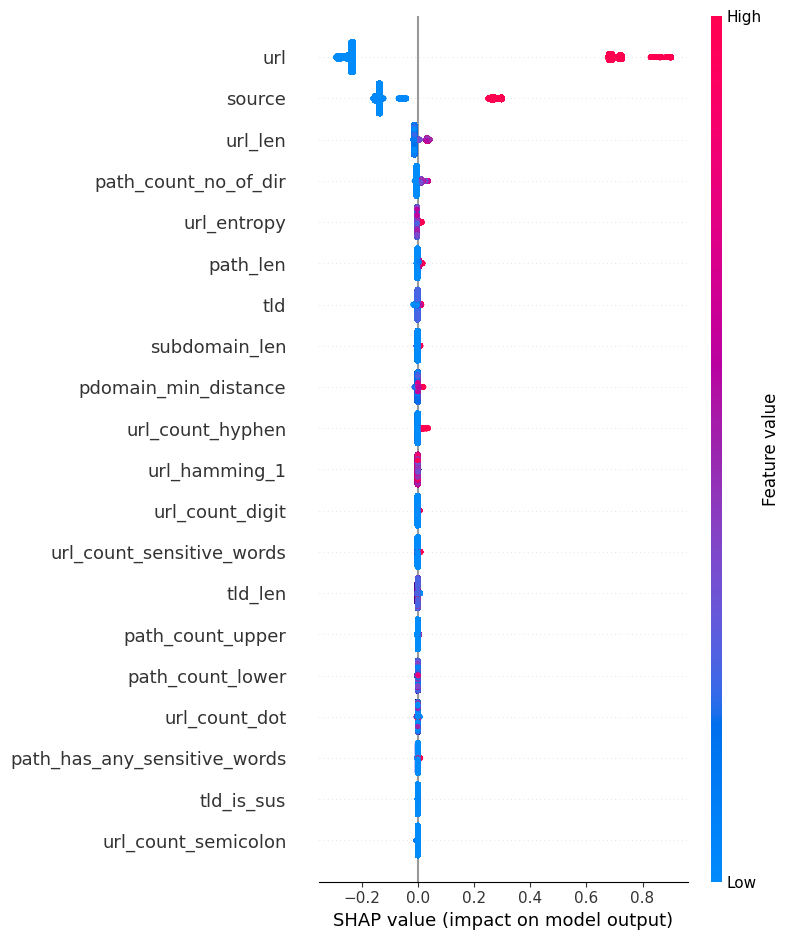

In [70]:
import shap

# Extract trained XGBoost model from pipeline
xgb_model = opt.best_estimator_.named_steps['clf']

# SHAP needs the training data IN THE SAME FORMAT fed to the model
X_train_enc = opt.best_estimator_.named_steps['encoder'].transform(X_train)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_enc)

# Global feature importance (how much each feature pushes predictions)
shap.summary_plot(shap_values, X_train_enc, plot_type="bar")

# More detailed version: shows direction (positive = more malicious)
shap.summary_plot(shap_values, X_train_enc)


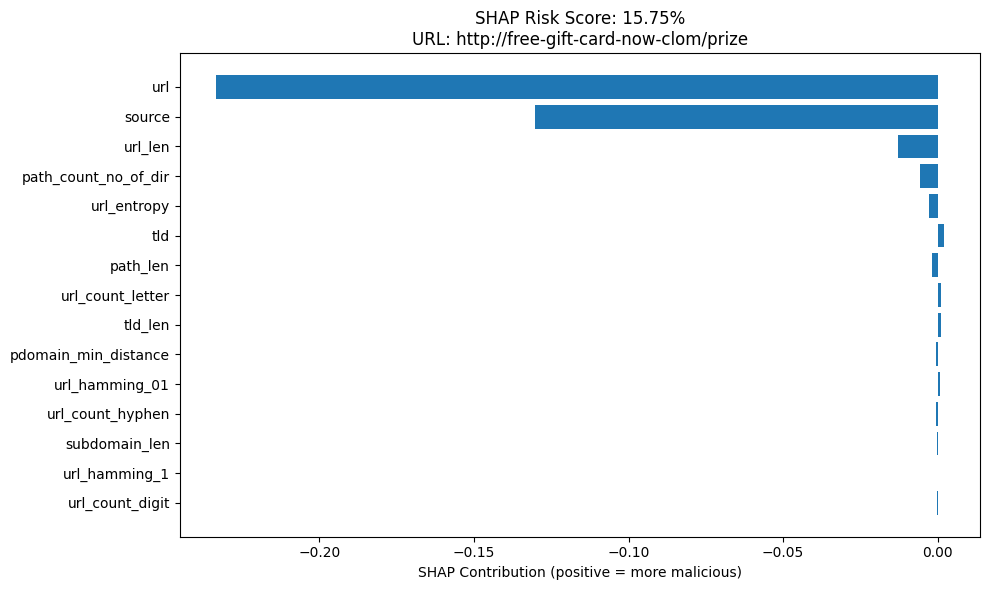

Risk: 15.747715950012207


In [72]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# SHAP-consistent probability reconstruction
# ============================================================
def shap_risk_from_shap_values(shap_vals, expected_value):
    shap_sum = shap_vals.sum()
    log_odds = expected_value + shap_sum
    prob = 1 / (1 + np.exp(-log_odds))
    return float(prob * 100)


# ============================================================
# Build complete feature row with correct columns
# (You will replace this later with full extractor)
# ============================================================
def build_feature_row(url: str, X_train):
    # Create empty row with EXACT training columns
    row = pd.DataFrame(columns=X_train.columns)
    row.loc[0] = 0

    # Only fill the columns that actually exist
    if "url" in row.columns:
        row["url"] = url

    if "url_length" in row.columns:
        row["url_length"] = len(url)

    if "num_digits" in row.columns:
        row["num_digits"] = sum(c.isdigit() for c in url)

    if "num_special" in row.columns:
        row["num_special"] = sum(not c.isalnum() for c in url)

    return row



# ============================================================
# SHAP bar chart + SHAP risk score
# ============================================================
def shap_bar_for_url(url: str, opt, explainer, X_train):
    # 1. Build raw feature row
    row = build_feature_row(url, X_train)

    # 2. Encode using TargetEncoder inside pipeline
    encoder = opt.best_estimator_.named_steps["encoder"]
    row_enc = encoder.transform(row)

    # 3. Compute SHAP values
    shap_vals = explainer.shap_values(row_enc)[0]
    expected_value = explainer.expected_value

    # 4. SHAP-based risk score
    risk_percent = shap_risk_from_shap_values(shap_vals, expected_value)

    # 5. Sort SHAP contributions
    feature_names = row_enc.columns
    shap_array = np.array(shap_vals)
    idx = np.argsort(np.abs(shap_array))[::-1]

    shap_array = shap_array[idx]
    feature_names = feature_names[idx]

    # 6. Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[:15], shap_array[:15])
    plt.gca().invert_yaxis()

    plt.title(
        f"SHAP Risk Score: {risk_percent:.2f}%\nURL: {url}",
        fontsize=12
    )
    plt.xlabel("SHAP Contribution (positive = more malicious)")
    plt.tight_layout()
    plt.show()

    return risk_percent

explainer = shap.TreeExplainer(opt.best_estimator_.named_steps["clf"])

input_url = "http://free-gift-card-now-clom/prize"
risk = shap_bar_for_url(input_url, opt, explainer, X_train)
print("Risk:", risk)




=== Testing URL ===
http://paypal-login-security-alert.com/verify


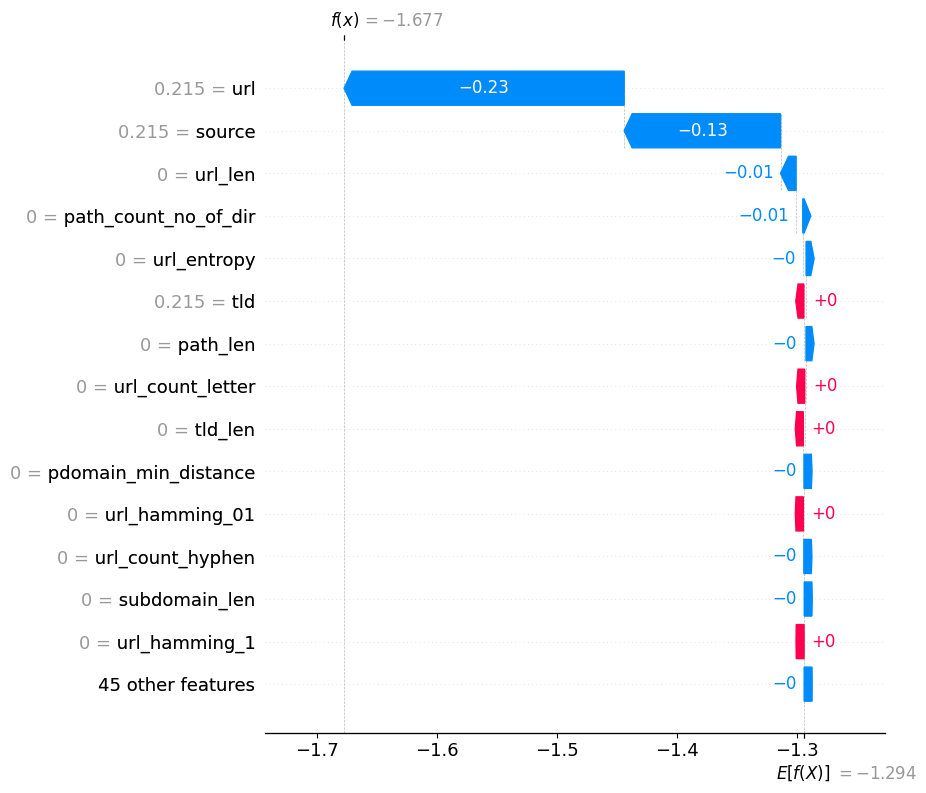

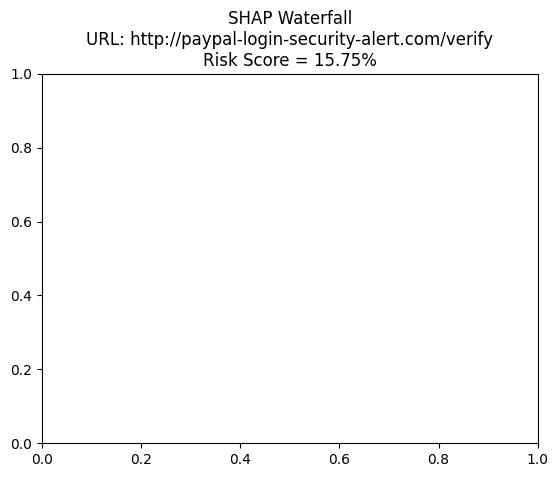

Risk Score: 15.75%

=== Testing URL ===
http://bankofamerica.secure-update-account.net/login


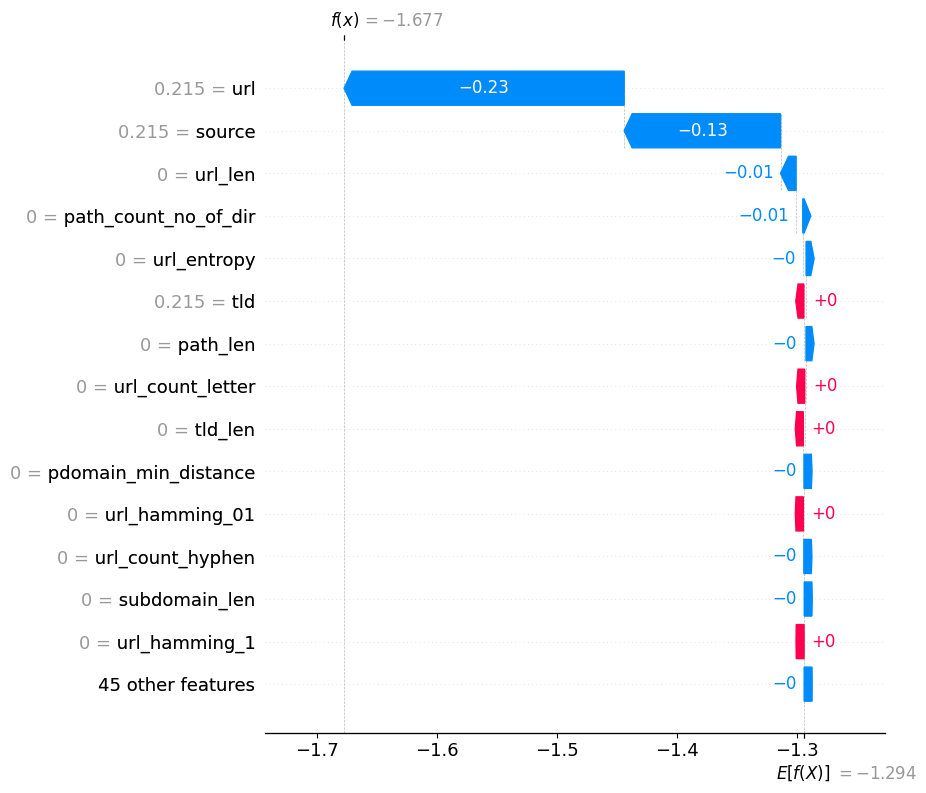

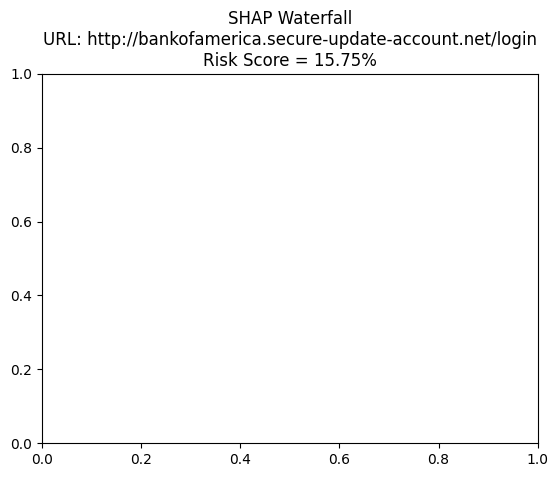

Risk Score: 15.75%

=== Testing URL ===
http://free-gift-card-now-clom/prize


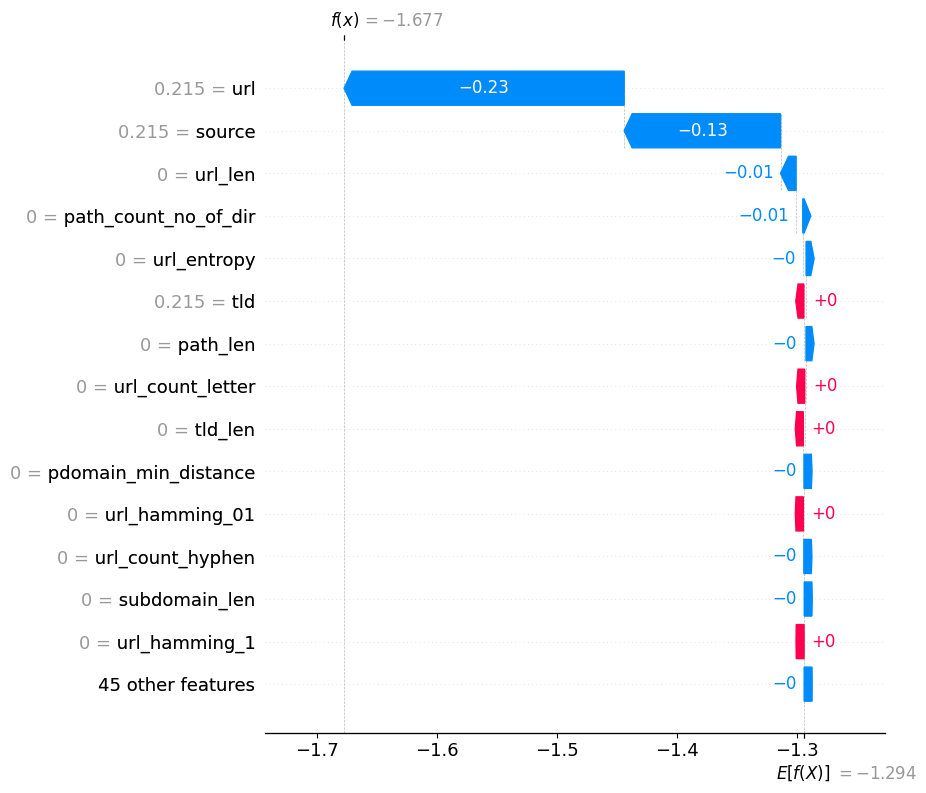

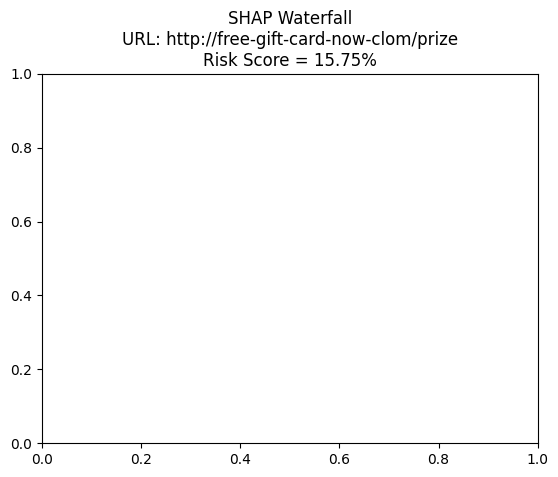

Risk Score: 15.75%

=== Testing URL ===
http://claim-your-tax-refund-irs-support.ru


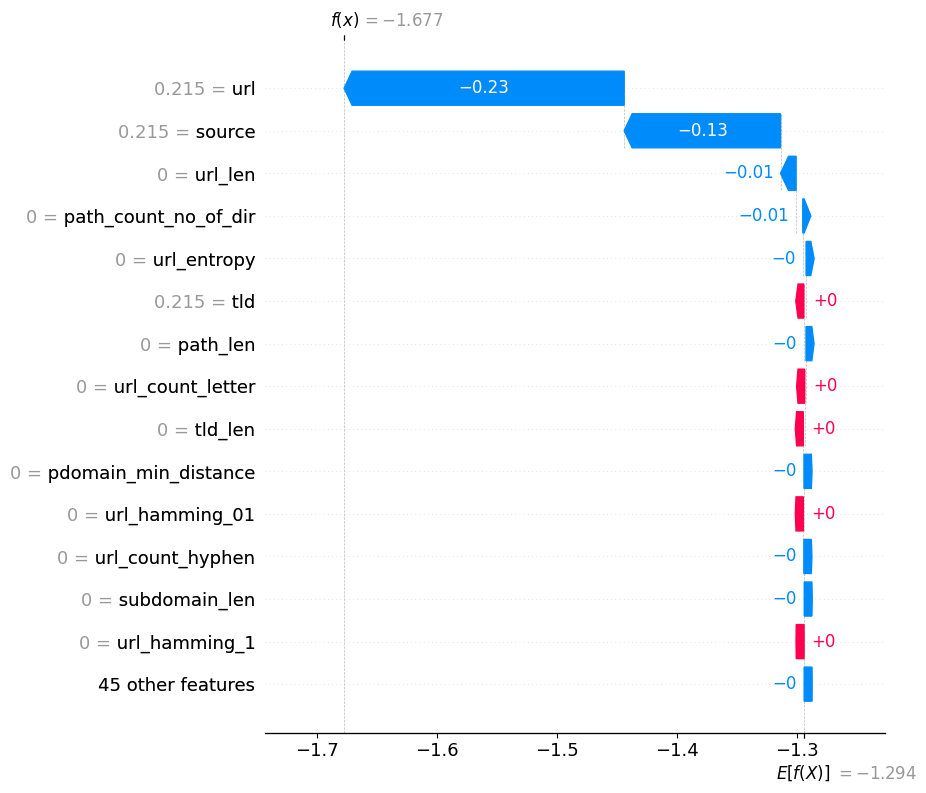

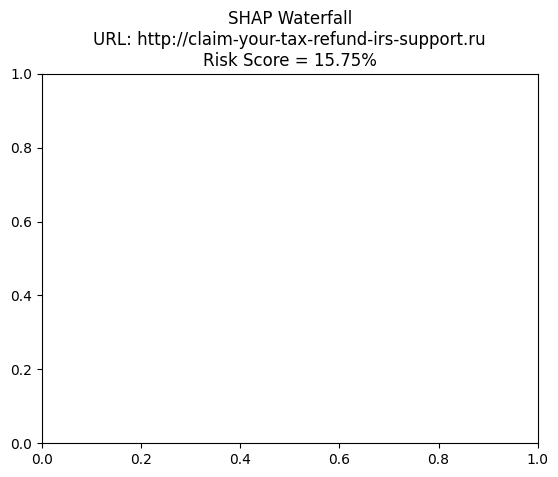

Risk Score: 15.75%

=== Testing URL ===
http://update-facebook-security-check-account.gq


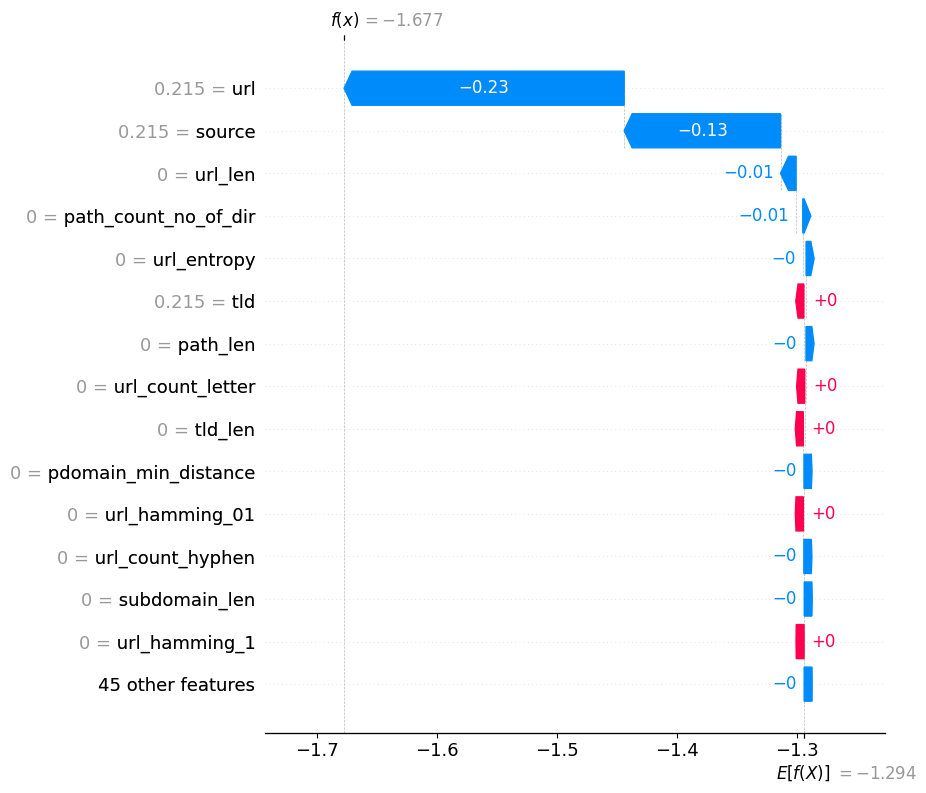

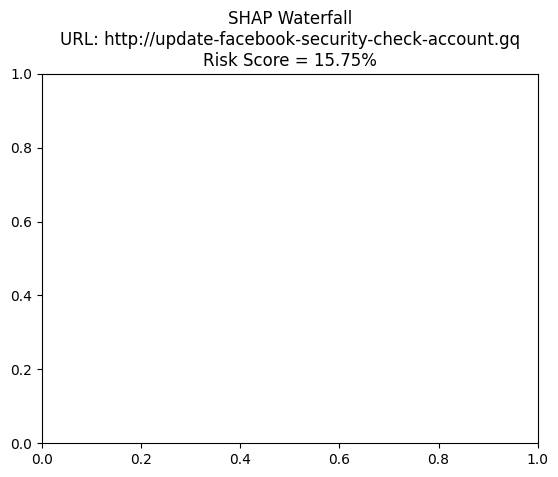

Risk Score: 15.75%


In [74]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# SHAP Probability Reconstruction
# ============================
def shap_risk_from_shap_values(shap_vals, expected_value):
    shap_sum = shap_vals.sum()
    log_odds = expected_value + shap_sum
    prob = 1 / (1 + np.exp(-log_odds))
    return float(prob * 100)


# ============================
# Build feature row (same columns)
# ============================
def build_feature_row(url: str, X_train):
    row = pd.DataFrame(columns=X_train.columns)
    row.loc[0] = 0

    if "url" in row.columns:
        row["url"] = url
    if "url_length" in row.columns:
        row["url_length"] = len(url)
    if "num_digits" in row.columns:
        row["num_digits"] = sum(c.isdigit() for c in url)
    if "num_special" in row.columns:
        row["num_special"] = sum(not c.isalnum() for c in url)

    return row


# ============================
# Waterfall plot for single URL
# ============================
def shap_waterfall_for_url(url, opt, explainer, X_train):
    # 1. Build feature row
    row = build_feature_row(url, X_train)

    # 2. Encode
    encoder = opt.best_estimator_.named_steps["encoder"]
    row_enc = encoder.transform(row)

    # 3. SHAP values
    shap_vals = explainer.shap_values(row_enc)[0]
    expected_value = explainer.expected_value

    # 4. Probability from SHAP contributions
    risk_percent = shap_risk_from_shap_values(shap_vals, expected_value)

    # 5. Build a SHAP explanation object
    shap_ex = shap.Explanation(
        values=shap_vals,
        base_values=expected_value,
        data=row_enc.iloc[0].values,
        feature_names=row_enc.columns.tolist()
    )

    # 6. Waterfall Plot
    plt.figure(figsize=(9, 7))
    shap.plots.waterfall(shap_ex, max_display=15)
    plt.title(f"SHAP Waterfall\nURL: {url}\nRisk Score = {risk_percent:.2f}%", fontsize=12)
    plt.show()

    return risk_percent
xgb_model = opt.best_estimator_.named_steps["clf"]
explainer = shap.TreeExplainer(xgb_model)

malicious_urls = [
    "http://paypal-login-security-alert.com/verify",
    "http://bankofamerica.secure-update-account.net/login",
    "http://free-gift-card-now-clom/prize",
    "http://claim-your-tax-refund-irs-support.ru",
    "http://update-facebook-security-check-account.gq",
]

for u in malicious_urls:
    print("\n=== Testing URL ===")
    print(u)
    risk = shap_waterfall_for_url(u, opt, explainer, X_train)
    print(f"Risk Score: {risk:.2f}%")
